In [18]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import functools

In [19]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.previous:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n.op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.op, label = n.op)
      # and connect this node to it
      dot.edge(uid + n.op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.op)

  return dot

What if we broke down the tanh function instead of being a blackbox? It will force us to implement the other operations. It worked as a blackbox because we knew what was the derivative of tanh.

In [20]:
class Value:
    def __init__(self, data, children=(), op='', label=''):
      self.data = data
      self.grad = 0.0
      self._backward = lambda: None
      self.previous = set(children)
      self.op = op
      self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
  
    def __add__(self, other):
      other = other if isinstance(other, Value) else Value(other)
      out = Value(self.data + other.data, (self, other), "+", )
      
      def _backward():
        self.grad += 1.0 * out.grad
        other.grad += 1.0 * out.grad

      out._backward = _backward
      return out
    
    def __sub__(self, other):
      return self + (-other)
    
    def __neg__(self):
      return self * -1
    
    def __radd__(self, other):
      return self + other
    
    def __mul__(self, other):
      other = other if isinstance(other, Value) else Value(other)
      out =  Value(self.data * other.data, (self, other), "*")

      def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad

      out._backward = _backward
      return out
    
    def __rmul__(self, other):
      return self * other
    
    def __truediv__(self, other):
      return self * other**-1
    
    def __pow__(self, other):
      assert isinstance(other, (int, float)) # only supporting int/float powers for now
      out = Value(self.data ** other, (self,), f"**{other}")
      
      def _backward():
        self.grad = (other * self.data ** (other - 1)) * out.grad
      
      out._backward = _backward
      return out

    def tanh(self):
        out = Value((math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1), (self,), 'tanh')

        def _backward():
          self.grad += (1 - out.data**2) * out.grad

        out._backward = _backward
        return out 

    def exp(self): 
      out = Value(math.exp(self.data), (self, ), 'exp')

      def _backward():
        self.grad += out.data * out.grad

      out._backward = _backward
      return out
    
    def backward(self):
      sorted = []
      visited = set()
      def dfs(value):
        if value not in visited:
          visited.add(value)
          for child in value.previous:
            dfs(child)
          sorted.append(value)
      dfs(self)
      self.grad = 1.0
      for value in reversed(sorted):
        value._backward()

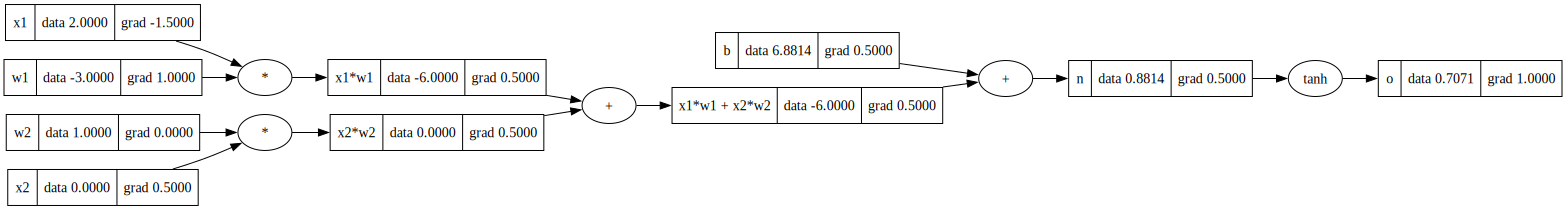

In [21]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

Now if we breakdown the tanh

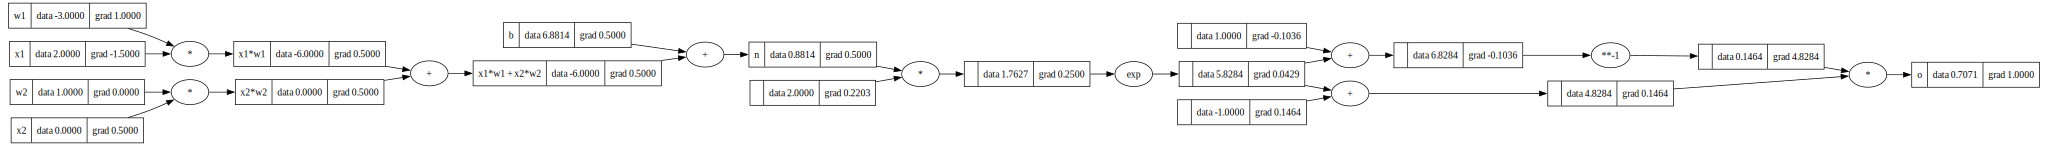

In [22]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# Now we define o
e = (2 * n).exp()
o = (e - 1) / (e + 1); o.label = 'o'
o.backward()
draw_dot(o)

Using PyTorch to accomplish the same result:

In [6]:
import torch

In [7]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
o.backward()

print(f"Output: {o.data.item()}")
print("Gradients:")
print(f"x1: {x1.grad.item()}")
print(f"x2: {x2.grad.item()}")
print(f"w1: {w1.grad.item()}")
print(f"w2: {w2.grad.item()}")


Output: 0.7071066904050358
Gradients:
x1: -1.5000003851533106
x2: 0.5000001283844369
w1: 1.0000002567688737
w2: 0.0


Now we are going to start building our neural net. Let's start with a single neuron.

In [23]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))
  
  # w * x + b
  def __call__(self, x):
    activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    return activation.tanh()
    
  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [neuron(x) for neuron in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
    

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    out = functools.reduce(lambda inputs, layer: layer(inputs), self.layers, x)
    return out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [24]:
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
mlp(x)

Value(data=-0.22744170191449034)

In this scenario we have four examples, with the corresponding desired targets. It is a very simple binay classifier.

In [25]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0]
] # Four examples
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

We need to tune the weights in order to make the predictions to match as much as possible with the desired targets. The trick used is to calculate a single number that measures the total performance of the neural net.
That value is called the `loss`. At first the loss will be hight. So we want to minimize the loss.
We will implement the loss as the mean squared error.

In [26]:
ypred = [mlp(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=5.451999317477497)

In [27]:
loss.backward()

-0.11627144161696253


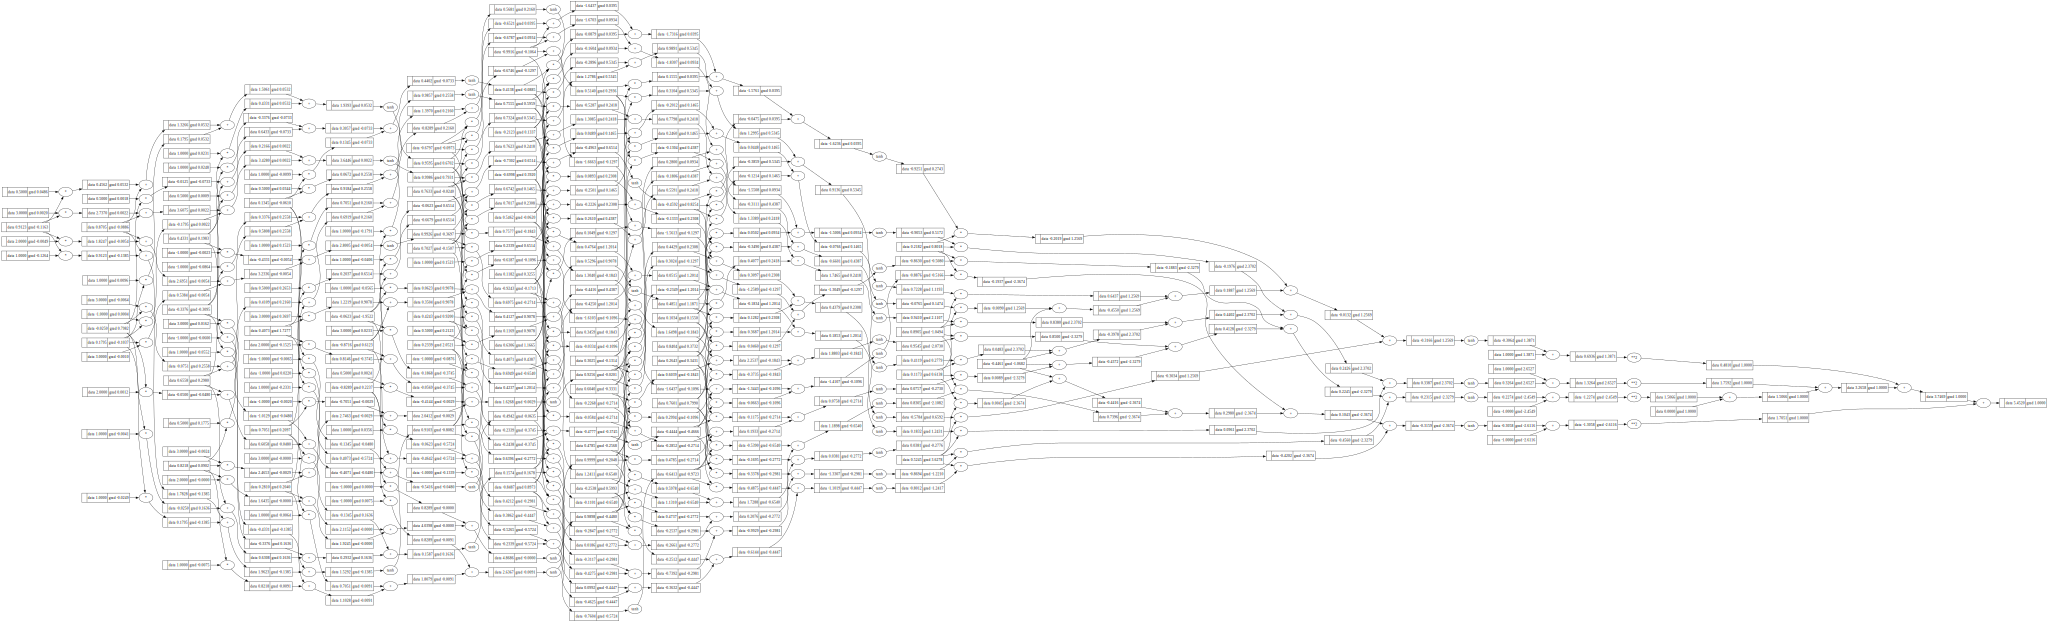

In [31]:
print(mlp.layers[0].neurons[0].w[0].grad)
draw_dot(loss)

In [13]:
print(mlp.layers[0].neurons[0].w[0].grad)
print(mlp.layers[0].neurons[0].w[0].data)

1.3529723188958203
-0.31825495480545585


We have to modify the parameters to reduce the loss function.

In [14]:
for p in mlp.parameters():
  p.data += -0.01 * p.grad

In [15]:
ypred = [mlp(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=5.349169550633344)

In [16]:
ypred

[Value(data=-0.706073216302561),
 Value(data=-0.9519204334759667),
 Value(data=-0.8886484881703649),
 Value(data=-0.5568471111013098)]

It's time to implement a training loop so that we don't have to manually train the network

In [17]:
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
mlp(x)

for k in range(20):
  # forward pass
  ypred = [mlp(x) for x in xs]
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

  # backward pass
  for p in mlp.parameters():
      p.grad = 0
  loss.backward()

  # update parameters
  for p in mlp.parameters():
    p.data += -0.05 * p.grad
  
  print(k, loss.data)

ypred

0 6.22152733262854
1 4.711549722455308
2 3.6266123975706495
3 2.683536490117789
4 1.8333064286250915
5 1.2425681648236562
6 0.9155527982202649
7 0.5087555725655598
8 0.33166458727454123
9 0.2681047583478719
10 0.2233379916929246
11 0.18998538608035315
12 0.16438094408312448
13 0.14423055418083744
14 0.1280373901700084
15 0.11479087087053164
16 0.1037881410716589
17 0.09452752259224498
18 0.08664268779639084
19 0.07986071795687912


[Value(data=0.84907415211477),
 Value(data=-0.9000396489414327),
 Value(data=-0.8248225649337373),
 Value(data=0.8719261898089354)]